# Install and import modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re

from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tqdm.notebook import tqdm
import ast
from matplotlib import pyplot as plt
import seaborn as sns
import pickle

In [2]:
%%capture
!pip install sentence-transformers
!pip install keybert
!pip install umap-learn
!pip install hdbscan

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [4]:
from keybert import KeyBERT
kw_model = KeyBERT()

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Load and preprosess data

In [5]:
df = pd.read_csv('../input/myanimelist-dataset-animes-profiles-reviews/animes.csv')
df = df.reset_index() 
df.dropna(inplace=True, subset=['synopsis', 'title'])
df = df[~df.uid.duplicated(keep='first')]
df.head()

,index,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...


In [6]:
# TITLE = 'Shingeki no Kyojin'
# title = TITLE
# doc = df[df['title'] == title].synopsis.values[0]
# doc = re.sub("[\(\[].*?[\)\]]", "", doc) # Remove the "written by" caption
# paragraphs = [p for p in doc.split("\n") if len(p) > 50]
# doc = paragraphs[2]

In [7]:
TITLE = 'Shingeki no Kyojin'
idx = df[df['title'] == TITLE].index
def get_synopsis(ind):
    doc = df.loc[idx].synopsis.values[0]
    doc = re.sub("[\(\[].*?[\)\]]", "", doc) # Remove the "written by" caption
    doc = doc.replace(u'\n', u'').replace(u'\r', u'')
    doc = nlp(doc)
    return doc
doc = get_synopsis(TITLE)
print(doc)

Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations.  After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga,  Shingeki no Kyojin  

# Extract keyword candidates

In [8]:
for nph in doc.noun_chunks: # use np instead of np.text
    if len(nph) > 1:
        print('> ', nph)

>  monstrous humanoid creatures
>  enormous concentric walls
>  these giants
>  their taste
>  human flesh
>  their survival
>  the remnants
>  defensive barriers
>  one hundred years
>  a single titan encounter
>  that fragile calm
>  a colossal titan
>  the supposedly impregnable outer wall
>  the fight
>  the man-eating abominations
>  a horrific personal loss
>  the hands
>  the invading creatures
>  Eren Yeager
>  his life
>  their eradication
>  the Survey Corps
>  an elite military unit
>  the merciless humanoids
>  the protection
>  the walls
>  Hajime Isayama's award-winning manga
>  his adopted sister
>  Mikasa Ackerman
>  his childhood friend
>  Armin Arlert
>  the brutal war
>  the titans
>  a way
>  the last walls


In [9]:
def get_keyword_candidates(doc):
    # code to recursively combine nouns
    # 'We' is actually a pronoun but included in your question
    # hence the token.pos_ == "PRON" part in the last if statement
    # suggest you extract PRON separately like the noun-chunks above

    index = 0
    nounIndices = []
    for token in doc:
        if token.pos_ == 'NOUN':
            nounIndices.append(index)
        index = index + 1

#     print('Nouns found: ', len(nounIndices))

    candidates = []
    for idxValue in nounIndices:
        if not bool(doc[idxValue].left_edge.ent_type_):
            start = doc[idxValue].left_edge.i
        else:
            start = idxValue 

        if not bool(doc[idxValue].right_edge.ent_type_):
            finish = doc[idxValue].right_edge.i+1
        else:
            finish = idxValue + 1

        if finish-start > 0 and finish-start <7:
            span = doc[start : finish]
#             print('>', span)
            candidates.append(span.text)

    return candidates

candidates = get_keyword_candidates(doc)
print(candidates)

['Centuries', 'mankind', 'humanoid', 'monstrous humanoid creatures called titans', 'titans', 'humans', 'fear', 'enormous concentric walls', 'these giants', 'their taste for human flesh', 'human flesh', 'hunger', 'pleasure', 'their survival', 'the remnants of humanity', 'humanity', 'defensive barriers', 'years', 'a single titan encounter', 'that fragile calm', 'the supposedly impregnable outer wall', 'man', 'the man-eating abominations', 'a horrific personal loss', 'the hands of the invading creatures', 'the invading creatures', 'his life', 'their eradication', 'merciless', 'the protection of the walls', 'the walls', 'award', 'manga,  ', 'his adopted sister', 'his childhood friend', 'the titans and race', 'race', 'the last walls']


In [10]:
keywords = kw_model.extract_keywords(doc.text, candidates=candidates, 
                              use_mmr=True, diversity=0.7)

keywords

[('monstrous humanoid creatures called titans', 0.5308),
 ('the protection of the walls', 0.3215),
 ('hunger', 0.2733),
 ('their eradication', 0.3178),
 ('merciless', 0.166)]

# Reduce embedding dimentions

In [11]:
import umap
import umap.plot
reducer = umap.UMAP(n_components=3)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Save/load for later:

In [12]:
keywords = np.load('../input/synopsis-keyword-clusterization/keywords.npy')
keyword_embeddings = np.load('../input/synopsis-keyword-clusterization/keyword_embeddings.npy')
ids = np.load('../input/synopsis-keyword-clusterization/ids.npy')
with open('../input/synopsis-keyword-clusterization/reducer.pkl', 'rb') as f:
    reducer = pickle.load(f)

In [13]:
# keywords = []
# keyword_embeddings = np.zeros((0,384))
# ids = []

# i = 0
# row = df.synopsis[0]
# for i, row in enumerate(tqdm(df.synopsis)):
#     doc = row
#     doc = re.sub("[\(\[].*?[\)\]]", "", doc) # Remove the "written by" caption
#     doc = doc.replace(u'\n', u'').replace(u'\r', u'')
#     doc = nlp(doc)
#     candidates = get_keyword_candidates(doc)
#     syn_keywords = kw_model.extract_keywords(doc.text, candidates=candidates, 
#                               use_mmr=True, diversity=0.7)
#     syn_keywords = [k[0] for k in syn_keywords]
#     if len(syn_keywords) > 0:
#         keyword_embeddings = np.append(keyword_embeddings, kw_model.model.embed(syn_keywords), axis=0)
#         keywords += syn_keywords
#         ids += [i]

In [14]:
np.save('keywords', np.array(keywords))
np.save('keyword_embeddings', keyword_embeddings)
np.save('ids', np.array(ids))

In [15]:
# %%time
# reducer.fit(keyword_embeddings)

In [16]:
with open('reducer.pkl', 'wb') as f:
    pickle.dump(reducer, f)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<AxesSubplot:>

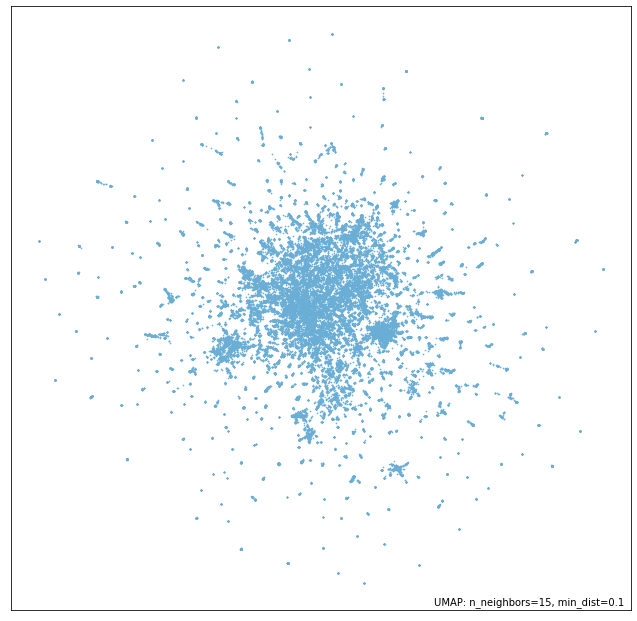

In [17]:
reduced = reducer.transform(keyword_embeddings)
umap.plot.points(reducer)

Ok, we can see some kind of clusters. Let's see if our clustering model can handle it:

# Clusterize

In [18]:
import hdbscan

In [19]:
%%time
clusterer = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=100,
    cluster_selection_epsilon = 0.1,
#     alpha=0.9
)
clusterer.fit(reduced)
labels = clusterer.labels_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

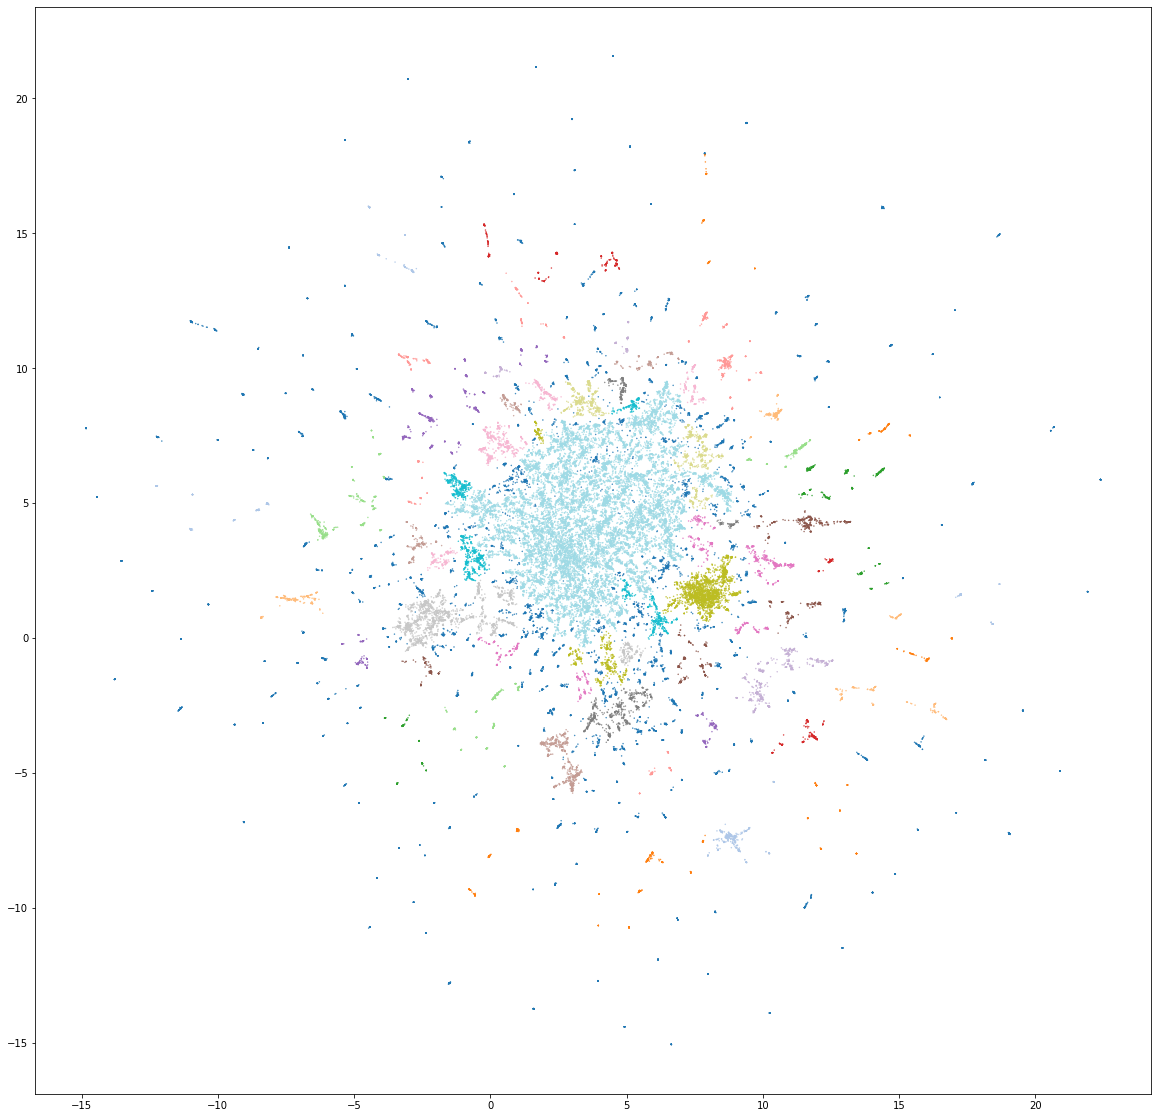

In [20]:
plt.figure(figsize=(20,20))
plt.scatter(reduced[:,0],reduced[:,1],c=labels,s=0.2,cmap='tab20')

In [21]:
results = pd.DataFrame()
results['class'] = labels
results['keywords'] = keywords
results['class'].value_counts()

 107    16858
-1       9605
 90      2367
 82      1261
 102      683
        ...  
 19       101
 41       101
 87       100
 73       100
 48       100
Name: class, Length: 109, dtype: int64

Let's look at some clusters to see if they make any sense:

In [22]:
results[results['class']==100].keywords.values

array(['his younger brother', 'his sister', 'the Bebaus brothers',
       'soon a sibling too', 'the needs of his little brother',
       'her "big sisters"', "exchange for his sister's eyesight",
       "her younger sister's place", 'sisters', 'his twin older brother',
       "The two siblings'", 'his sister', 'hardened brothers',
       'the young siblings', 'His sister, Nunnally,',
       'her eighth grade sister', 'her older sister',
       'his younger brother', 'his brother', 'shut-in NEET siblings',
       'both siblings', 'her younger brother',
       'the three oldest siblings', 'big sister like figure',
       'the three sworn brothers', 'the siblings',
       "her brother's ridiculous antics",
       'the clutches of his violent sister',
       'strict and diligent eldest sister', 'these siblings',
       'his brother', 'wild delusions about her brother',
       'his little brother', 'the brother', 'each brother', 'sisters',
       'her older sister', 'brothers', 'sexy siste

Ok looks like almoust all of the keywords in cluster 100 endeed have something to do with siblings